<a href="https://colab.research.google.com/github/LeoProvorov/MyProjects/blob/master/ML_DiKaprio_visual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Что общего у Ди Каприо и машинного обучения?**

In [ ]:
import pandas as pd
import numpy as np

from google.colab import files

In [ ]:
files.upload() # Загрузка архива с кегл. Закидываем файл json сюда

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"leoprovorov","key":"f72a24d5b548dd8901a47dbea22a4373"}'}

In [ ]:
# Расположение файла для аутентификации на kaggle.com и получение прав доступа
!mkdir -p ~/.kaggle
!mv -i kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

mv: overwrite '/root/.kaggle/kaggle.json'? n


In [ ]:
# загрузка данных
!kaggle competitions download -c titanic

gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Чтение данных
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [ ]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Считывание целевой переменной в отдельный массив
len_train_data = len(train_data)
y = train_data['Survived'].values
print('Количество позиций для обучения', len_train_data)
print(y[:10])

Количество позиций для обучения 891
[0 1 1 1 0 0 0 0 1 1]


In [ ]:
# Переиндексируем данные и удаляем некоторые столбцы
train_data.index = train_data.PassengerId
del train_data['Survived']
del train_data['PassengerId']

test_data.index = test_data.PassengerId
del test_data['PassengerId']

train_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
#  Сливаем данные в один датасет, для более полной визуализации
all_data = pd.concat([train_data,test_data])
print('Размер полученных данных:', all_data.shape)
all_data.head(2)

In [ ]:
# Переводим номер кабины в 0-1
all_data['Has_Cabin'] = all_data['Cabin'].apply(lambda x: 0 if type(x) == float else 1) 

# Размер семьи
all_data['Family_Size'] = all_data['SibSp'] + all_data['Parch'] + 1

# Признак одинокого плавания
all_data['Is_alone'] = all_data['Family_Size'].apply(lambda x: 0 if x>1 else 1)


In [ ]:
# Использование регулярных выражений для поиска титулов в именах
import re
def get_title(name):
    title_search = re.search('([A-Za-z]+)\.', name) # Берём все буквы до точки
    if title_search:
        return title_search.group(1)
    return ""

# Применяем к столбцу Name
all_data['Title'] = all_data['Name'].apply(get_title)


In [ ]:
# просмотр титулов и из кол-во
all_data['Title'].value_counts()

In [ ]:
# исправление неточностей в титулах и замена редких на нейтральное значение
all_data['Title'] = all_data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Rev', 'Major', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
all_data['Title'] = all_data['Title'].replace('Mlle', 'Miss')
all_data['Title'] = all_data['Title'].replace('Ms', 'Miss')
all_data['Title'] = all_data['Title'].replace('Mme', 'Mrs')

In [ ]:
all_data['Title'].value_counts()

In [ ]:
# Дропаем ненужное
all_data = all_data.drop(["Name", 'Ticket', 'Cabin'], axis = 1)

In [ ]:
all_data.head(2)

In [ ]:
# Переводим оставшиеся недообработанные столбцы в числовой вид
title_mapping = {'Mr': 1, "Master": 2, "Mrs":3, "Miss":4, "Rare": 5}
all_data["Title"] = all_data["Title"].map(title_mapping)
all_data["Title"] = all_data['Title'].fillna(0) # здесь не нужен, но всёравно сделаем

In [ ]:
map_dict_sex = {'male': 1, 'female': 0}

all_data["Sex"] = all_data["Sex"].map(map_dict_sex)

In [ ]:
map_dict_embarked = {'S': 0, 'C': 1, 'Q': 2}

all_data['Embarked'] = all_data['Embarked'].map(map_dict_embarked)

In [ ]:
all_data.head(3)

In [ ]:
all_data.info()
#видим пропуски в данных, особенно в возрасте

In [ ]:
# Избавление от пропусков в данных
all_data['Fare'] = all_data['Fare'].fillna(value=all_data['Fare'].median())
all_data['Embarked'] = all_data['Embarked'].fillna(value=0)

In [ ]:
all_data['Age'] = all_data['Age'].fillna(value=all_data['Age'].mean())

In [ ]:
all_data.info()

In [ ]:
all_data.head()

**Дополнительная предоброботка данных**

In [ ]:
# Добавление названий категориальных столбцов
categorial_culumns_names = ['Pclass', 'Sex', 'SibSp', 'Parch',
                            'Embarked', 'Has_Cabin', 'Family_Size',
                            'Is_alone', 'Title']

# Кодируем категориальные данные по принципу One-Hot
from sklearn.preprocessing import  OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
encoded_categorial_columns = pd.DataFrame(
                                        one_hot_encoder.fit_transform(
                                        all_data[categorial_culumns_names]),
                                        index=all_data.index)

encoded_categorial_columns.head(10)

In [ ]:
# Соединяем закодированные категориальные признаки с остальными
res_data_all = all_data.join(encoded_categorial_columns)
res_data_all.head()

In [ ]:
# избавлемся от категориальных столбцов в res_data_all
res_data_all = res_data_all.drop(categorial_culumns_names, axis=1)
res_data_all.head()

In [ ]:
# Нормализуем данные
from sklearn.preprocessing import  StandardScaler
nn_scaler = StandardScaler()
res_data_all_scaled = nn_scaler.fit_transform(res_data_all)

print(res_data_all_scaled.shape)
print(res_data_all_scaled[0])

In [ ]:
# Разбиваем на обучение и валидацию
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(res_data_all_scaled[:len_train_data],
                                                  y,
                                                  test_size=0.10,
                                                  random_state=42)

# **Часть 2. Статистический анализ и основная визуализация**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
target = train_data['Survived'].values


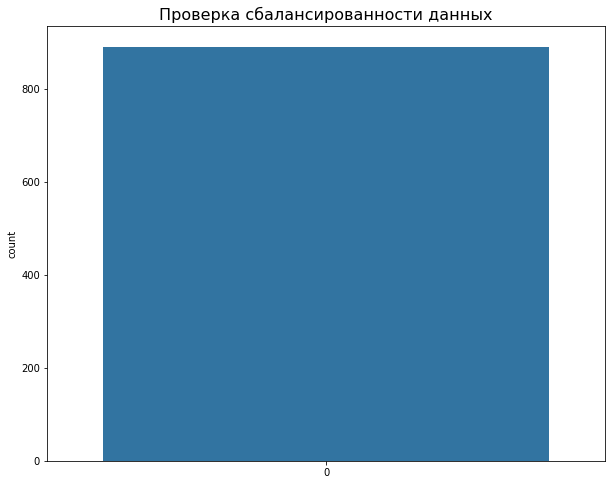

In [98]:
plt.figure(figsize=(10,8))
plt.title('Проверка сбалансированности данных', fontsize=16)
sns.countplot(data=y)

PassengerId
1      0
2      1
3      1
4      1
5      0
      ..
887    0
888    1
889    0
890    1
891    0
Name: Survived, Length: 891, dtype: int64

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,